In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import coronavirus as co
import pandas as pd
import matplotlib.pyplot as plt

germany_c, germany_d = co.get_country("Germany")

china_c, china_d = co.get_country("China")
italy_c, italy_d = co.get_country("Italy")
us_c, us_d = co.get_country("US")


italy_c

In [2]:
def day0atleast(v0, series):
    day0 = series[series > v0].index[0]

    # compute timedelta  
    timedelta = series.index - day0
    # convert to int as index
    t = pd.to_numeric(timedelta.astype("timedelta64[D]").astype(int))
    # Assemble new series
    result = pd.Series(index=t, data=series.values)
    
    return result
    

In [3]:
def day0for(v0, series, country=None):
    """Expect a series with DateTimeIndex and values
    
    Return a series with integers as index (representing days) since the day at which the 
    value is closest to v0.
    """
    # identify the index closest to value v0
    if country=="Italy":
        day0 = series.loc["2020-02-15":"2020-03-15"].sub(v0).abs().astype('float').idxmin()
    elif country=="China":
        day0 = series.loc["2020-01-15":"2020-03-30"].sub(v0).abs().astype('float').idxmin()
    else:
        day0 = series.sub(v0).abs().astype('float').idxmin()        
    # compute timedelta  
    timedelta = series.index - day0
    # convert to int as index
    t = pd.to_numeric(timedelta.astype("timedelta64[D]").astype(int))
    # Assemble new series
    result = pd.Series(index=t, data=series.values)
    
    print(f"day0 = {day0}, country={country}")

    return result
    
    

In [4]:
def align_sets_at(v0, df):
    """Accepts data frame, and aligns so that all enttries close to v0 are on the same row.
    
    Returns new dataframe with integer index (reprenting days after v0).
    """
    res = pd.DataFrame()

    for col in df.columns:
        # res[col] = day0for(v0, df[col])
        series = day0atleast(v0, df[col])
        series.name = col
        res = pd.merge(res, series, how='outer', left_index=True, right_index=True)

    return res

In [5]:
def compare_data(countrynames, rolling=7):
    """Given a list of country names, return two dataframes: one with cases and one with deaths
    where
    - each column is one country
    - data in the column is the diff of accumulated numbers
    - any zero values are removed for italy (data error)
    - apply some smoothing
    """
    df_c = pd.DataFrame()
    df_d = pd.DataFrame()
    
    for countryname in countrynames:
        c, d = co.get_country(countryname)
        #df_c[countryname] = c.diff().rolling(14, win_type='gaussian').sum(std=7)
        #df_d[countryname] = d.diff().rolling(14, win_type='gaussian').sum(std=7)
        #df_c[countryname] = c.diff().rolling(7, win_type='gaussian').mean(std=7)
        #df_d[countryname] = d.diff().rolling(7, win_type='gaussian').mean(std=7)

        df_c[countryname + ' cases'] = c.diff().rolling(rolling, center=True).mean()
        df_d[countryname + ' deaths'] = d.diff().rolling(rolling, center=True).mean()        

    return df_c, df_d



r = pd.DataFrame()

r1 = pd.merge(r, ser2, how='outer', left_index=True, right_index=True)

r2 = pd.merge(r1, ser1, how='outer', left_index=True, right_index=True)

In [76]:
"test" in None

TypeError: argument of type 'NoneType' is not iterable

In [77]:
def plot_logdiff_time(ax, df, xaxislabel, yaxislabel, style="", labels=True, labeloffset=2, v0=0,
                     highlight={}, other_lines_alpha=0.3):
    """highlight is dictiorany: {country_name : color}"""
    for i, col in enumerate(df.columns):
        if col in highlight:
            alpha = 1.0
            color = highlight[col]
        else:
            alpha = other_lines_alpha
            color = style + 'C' + str(i)

        ax.plot(df.index, df[col].values, color, label=col, linewidth=2.5, alpha=alpha)
        if labels:
            tmp = df[col].dropna()
            x, y = tmp.index[-1], tmp.values[-1]
            ax.annotate(col, xy=(x + labeloffset, y), textcoords='data') 
            ax.plot([x], [y], "oC" + str(i), alpha=alpha)
    # ax.legend()
    ax.set_ylabel(yaxislabel)
    ax.set_xlabel(xaxislabel)
    ax.set_yscale('log')
    # ax.set_xscale('log')   # also interesting
    ax.set_ylim(bottom=v0)
    ax.set_xlim(left=-1)  #ax.set_xlim(-1, df.index.max())
    ax.tick_params(left=True, right=True, labelleft=True, labelright=True)
    ax.yaxis.set_ticks_position('both')


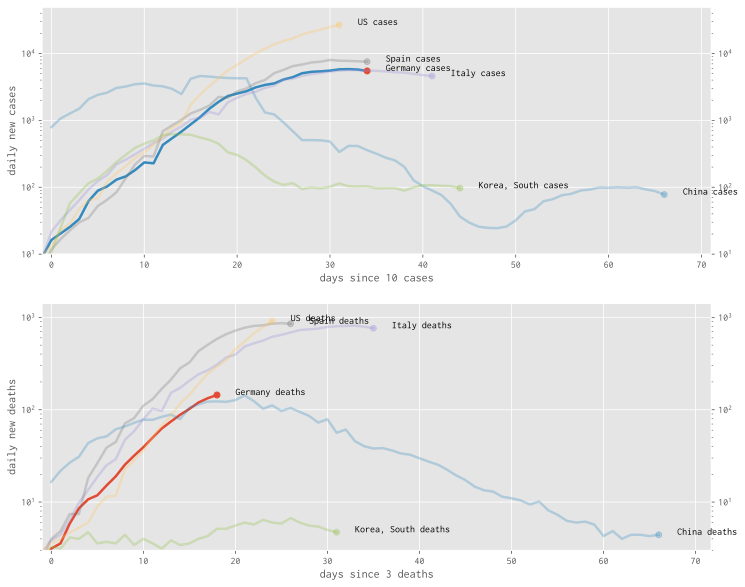

In [80]:
df_c, df_d = compare_data(["Germany", "China", "Italy", "Spain", "US", "Korea, South"])
# df_c, df_d = compare_data(["Germany", "Italy", "China"])
v0c = 10
v0d = 3
res_c = align_sets_at(v0c, df_c)
res_d = align_sets_at(v0d, df_d)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
ax=axes[0]
plot_logdiff_time(ax, res_c, f"days since {v0c} cases", "daily new cases", v0=v0c, highlight={"Germany cases":"C1"})
ax = axes[1]
plot_logdiff_time(ax, res_d, f"days since {v0d} deaths", "daily new deaths", v0=v0d, highlight={"Germany deaths":"C0"})